#### The Need for MapReduce
* CPUs execute operations on data loaded into RAM
* Large datasets must be read from disk into RAM
* Issues arise when data cannot fit into RAM
* CPU cost is often discussed, but I/O cost is generally overlooked
* Reading large files is I/O-bound, not necessarily CPU-bound
* Disk I/O speed limits data processing


#### Disk Speed Benchmarking
* Open-source disk speed benchmarking with `fio`
  * [How Fast are Your Disks?](https://arstechnica.com/gadgets/2020/02/how-fast-are-your-disks-find-out-the-open-source-way-with-fio/) (2/6/2020)
  * FIO: Flexible I/O is a tool that helps you benchmark and verify disk I/O performance.
  * A really useful tool for data engineers
  
```bash
fio --name=test --ioengine=sync --rw=randwrite --bs=4k --numjobs=1 --size=100m --time_based --runtime=60s
```



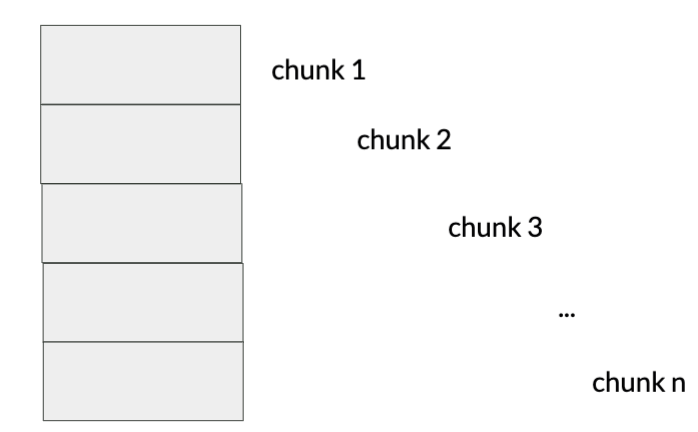

### Issue with Batching and I/O Costs
* While CPU costs are often a focal point in discussions about performance, the cost of I/O (Input/Output) is frequently overlooked.
* Even operations that are not CPU-intensive can become bottlenecks when dealing with large files due to the limitations of I/O speed.
* A standard 7200 RPM HDD typically offers a read/write speed ranging from 80 to 160 MB/s.
* Higher-end drives, like 15k RPM HDDs or SSDs, can offer significantly faster speeds, averaging around 350 MB/s.
Reading a very large file can be time-consuming.
* At a speed of 200 MB/s, it would take approximately 11 GB per minute or around 703 GB per hour to read a file.
  * For example, reading a 200 TB file would require more than 200 hours.
* Another challenge is memory constraints
  * Since it's often infeasible to store large files in RAM, each operation on the file necessitates reading the entire file from disk again.

#### Using GNU Parallel
* GNU Parallel allows concurrent execution of commands or shell scripts
    * Local and distributed execution via SSH
    * [GNU Parallel Tutorial](https://www.admin-magazine.com/HPC/Articles/GNU-Parallel-Multicore-at-the-Command-Line-with-GNU-Parallel)
    * [Parallel-SSH](https://www.tecmint.com/run-commands-on-multiple-linux-servers/)



#### GNU Parallel Example: Word Count

```bash
# Remove empty lines
awk NF t8.shakespeare.txt > text_no_empty_lines.txt
# Split into chunks
split -l 500 text_no_empty_lines.txt text_subset_
# Process chunks using Parallel
ls text_subset* | grep -v map | parallel "awk 'BEGIN {RS=\"[[:punct:][:space:]]+\"} {print \$0}' {} > {}.map"
ls *.map | parallel "sort {} | uniq -c > {}.counts"
```


* Combining all the counts can be then achived using:
```bash
cat *.counts | sort -k2,2 | awk '{counts[$2]+=$1} END {for (word in counts) print counts[word], word}' | sort -k1,1nr -k2,2
```


### Parallel and SSH

* Parallel gas the capability to distribute tasks across multiple machines using SSH

```bash
ls text_subset* | parallel --sshloginfile sshnodes \
     --dry-run \
     --transfer \
     --return {}.map \
     --cleanup \
      "<command>"
````

* Need to handle file transer, program installtion on remote machines, etc.



### Challenges in the Current Approach
* Complexity of Distributed Programming
  * Even for straightforward examples like the one discussed, there are multiple steps involved: splitting the data, transferring it, and finally merging the results.

* Lack of Redundancy
  * With a server failure rate of once every 3 years, a system with 1000 servers would experience approximately one failure per day.
    * For context, Google manages an estimated 2.5 million machines. [Source](https://www.datacenterknowledge.com/archives/2017/03/16/google-data-center-faq)
* Data Transfer Overheads
  * Shuttling data back and forth adds significant computational costs.


### What is an HPC Cluster
* High-Performance Computing (HPC)aggregating computing power to solve complex problems in science, engineering, or other fields
  * HPC systems often consist of clusters of computers that work in parallel to perform tasks more quickly and efficiently than using a single machine.
* Example of a cluster topology [Apollo2](https://docs.hpc.sussex.ac.uk/apollo2/)
<div align="center">
    <img src="https://docs.hpc.sussex.ac.uk/apollo2/_images/hpc-diagram.png" width=800?>
</div>

#### The HPC Approach
* Distribute file chunks across multiple machines.
* Each machine processes its chunk independently.
* Effective for batch-like operations.
* Pros:
  * This approch is often called embarrassingly or delightfully or pleasingly parallel.
  * Requires little effort to parallelize.
* Cons:
  * Distributed programs are complex to manage.
    * E.g.: how do we split data, how do transer it, how do we know it completed successfully, what happens if a server dies? 
  * Lack of redundancy and fault tolerance.

#### MapReduce to the Rescue
* Framework on top of HPC clusters
* Addresses fault tolerance, data redundancy
* Map Reduce Components
    * Distributed File System
        * Data chunks replicated across nodes
        * Metadata managed by master nodes
    * Mapping and Reducing
        * Mapping: Assign initial values to keys
        * Reducing: Aggregate initial values

#### Open-Source MapReduce Implementations
* Hadoop
    * Implemented in Java
    * Hadoop Distributed File System (HDFS)
* High-Level Abstractions
    * Hive: SQL-like language
    * Pig: Pig-Latin scripting language

### What a MapReduce Framework Needs to Provide:
* Data Partitioning: Keeping track of data chunks and their locations on different machines.
* Task Scheduling: Distributing program execution across available nodes.
* Node Availability: If there are more chunks than nodes, monitor when a node finishes its task to assign a new chunk.
* Result Management: Observing execution to process the results.
* Inter-Machine Communication: Managing necessary data exchange between machines.
* Failure Recovery: Handling node failures by reassigning their tasks to other available machines.
* Developer-Friendly: The framework requires developers to write only the map and reduce functions.
  * Provide implementation of common operations
  * E.g., what happens during a `group by`?


In [8]:
# On Linux
# !head -c 1G </dev/urandom > /tmp/myfile
# BE EXTRA CARFUL WITH THE FOLLOWIN
!dd if=/dev/zero of=/tmp/temp_10GB_file bs=1024 count=10485760


10485760+0 records in
10485760+0 records out
10737418240 bytes transferred in 25.492404 secs (421200693 bytes/sec)


In [15]:
!du -sch /tmp/temp_10GB_file

In [14]:
%%timeit
# Running on a solid state drive.
for _ in open("/tmp/temp_10GB_file", "rb").readlines():
  pass


9.08 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Map Reduce -- Distributed file system
* Chunks are (16-64 MB) replicated across chunk servers (compute nodes)
  * Typically 3 replicates per chunk
  * No two chunks are on the same machine
  * preferably across node racks
* Catalogue of where each chunk is stored on a master nodes

### MapReduce Through an Example: Word Counting 

* Use Case: Counting words in a large document
  * Analogous to the task of reading K-mers in a DNA sequence
* Memory Constraints: Word counts exceed available RAM, requiring multiple machines.
* Chunk Management: The main cluster node keeps track of the location of each data chunk.
* Mapping Step: Individual nodes perform the 'mapping' of words to initial counts.
* Reducing Step: Specific nodes take on the task of 'reducing' initial counts to final totals.

<div align="center">
    <img src="https://www.dropbox.com/s/jwop5elec8trs5m/map_recude_words_example.png?dl=1" width=850>
</div>

### The Key-Value Pair in Hadoop
* The Key-Value pair <K, V> is the core entity processed by a MapReduce job.
  * Both map and reduce phases use Key-Value pairs for input and output.
  * All data in MapReduce is formatted as a Key-Value pair <K, V>

* Keys are used to partition data so that all values with the same key go to the same reducer.
* Keys also sort the data, grouping values by their associated key for easier processing by the reducer.
* The reducer combines all values associated with the same key into a single value.
* The reducer performs computations like sum, average, etc., on all values associated with the same key to produce the final result.


### Roles of the Map-Reduce Framework
* Data Partitioning: Divides the data into chunks and keeps track of their locations.
* Task Scheduling: Coordinates the program's execution across multiple nodes.
* Execution Monitoring: Oversees the runtime progress of tasks.
* Grouping by Keys: Organizes data based on specified keys during the reduce phase.
* Intermachine Communication: Manages data and control flow between nodes.
* Fault Handling: Addresses node failures and reallocates tasks as needed.

### Role of Master Node

* Keeps track of the status of the task
  * idle, in progress, or completed
* Idle tasks are scheduled as workers become available
* When a map task completes it sends the master the location of its R intermediate files
  * Each of the R intermediate files is associated with the reducer task
  * The master pushes info to reducers
  * Reduced do not start computaiton (or file copies) until all map tasks are completed
* Master pings workers to detect compute node failures
  * Resets to idle all map tasks that ran on that compute node
  * Resets to idle in progress reduce tasks on the compute node

### Map-Reduce Techniques for Non-Standard Operations

* Some operations can't be easily reduced to a single value using the basic Map-Reduce approach.
    * For instance, calculating the average or median is more complex than simply summing numbers.
```python
    >> np.mean([1,1,1,1,1,1,1,1,8])
    1.777
    >> np.mean([np.mean([1,1,1,1,1]), np.mean([1,1,1,8])])
    1.875
````


### Map-Reduce Techniques for Non-Standard Operations

* Trick for Calculating Averages:
  * The combiner generates a key-value pair `<k1, (sum_k1_i, count_k1_i)>` for each compute node `i`. 
  * Here, `sum_k1_i` is the sum of the values and `count_k1_i` is the number of values.
* The reducer then computes the true average as follows:
```bash
    <k1, (sum_k1_1 + sum_k1_2 + ... + sum_k1_i) / (count_k1_1 + count_k1_2 + ... + count_k1_i)>
```

* Example:
    - Combiner 1 outputs: `<k1, (5, 5)>`  (because 1+1+1+1+1 = 5, count = 5)
    - Combiner 2 outputs: `<k1, (13, 4)>`  (because 1+1+1+8 = 11, count = 4)
    - Reducer calculates: `<k1, (5 + 11) / (5 + 4)>` = `<k1, 16 / 9>` = `<k1, 1.777>`




### Map-Reduce Techniques for Non-Standard Operations

* How can we use map reduce to compute the median, assuming the number unique values is not too much?
  


### MapReduce Median

* Map each number in the input data to a key-value pair where the key is the number itself and the value is the count of 1. 
```bash
Input: [4, 2, 2, 9, 1, 5, 5]
Output: [(4, 1), (2, 1), (2, 1), (9, 1), (1, 1), (5, 1), (5, 1)]
```
* Reducer takes the key-value pairs and sums the values for each key. This will give the count of each unique number.
```bash
Input: [(4, 1), (2, 1), (2, 1), (9, 1), (1, 1), (5, 1), (5, 1)]
Output: [(1, 1), (2, 2), (4, 1), (5, 2), (9, 1)]
```
* Sort the list based on the keys(assumes relativey small number of values)
```bash
Sorted Output: [(1, 1), (2, 2), (4, 1), (5, 2), (9, 1)]
```
* Compute the median based on the counts and keys.

In [ ]:
### MapReduce Exercices

* Can you Compute the MapReduce version of `max`
* Can you develop a MapReduce recommendation system where if A is friends with B and B is friends with C, then A gets a recommendation to be friends with C?

### MapReduce Max Mappers Across Nodes

* Data (`[4, 2, 2, 9, 1, 5, 5]`) partitioned across reducers

```bash
reducer 1: Input: [4, 2, 2]
        Output: [('max', 4), ('max', 2), ('max', 2)]

reducer 2: Input: [9, 1]
        Output: [('max', 9), ('max', 1)]

reducer 3: Input: [5, 5]
        Output: [('max', 5), ('max', 5)]
```

### MapReduce Max - Reducers on Individual Nodes
```bash
Node 1: Input: [('max', 4), ('max', 2), ('max', 2)]
        Intermediate Steps:
            max_so_far = 4
            max_so_far = max(4, 2) = 4
            max_so_far = max(4, 2) = 4
        Output: [('max', 4)]

Node 2: Input: [('max', 9), ('max', 1)]
        Intermediate Steps:
            max_so_far = 9
            max_so_far = max(9, 1) = 9
        Output: [('max', 9)]

Node 3: Input: [('max', 5), ('max', 5)]
        Intermediate Steps:
            max_so_far = 5
            max_so_far = max(5, 5) = 5
        Output: [('max', 5)]
```

### MapReduce Friend Recommendation

* Goal: Recommend new friends based on existing friendships
* Input Friendship Pairs `[(A, B), (B, C), (B, D), (C, E)]`

* Mapper:
  * Emit the existing friendship

 ```
  [(A, B), (B, A),
   (B, C), (C, B),
   (B, D), (D, B),
   (C, E), (E, C)]
```


### MapReduce Friend Recommendation -- Mapper

* Emit friend-of-friend recommendations

```
# For (B, C):
Emit existing friendship: (B, C), (C, B)
Emit friend-of-friend for B: (A, C), (D, C)
Emit friend-of-friend for C: (B, E)
```

### MapReduce Friend Recommendation -- Reducer

* Original input `[(A, B), (B, C), (B, D), (C, E)]`

Reducer Input: [(A, B), (A, C), (A, D), (B, C), (B, E), (C, B), (D, C), (E, C)]

* Reduce by filtering out exisiting friendships (Compute difference)
  *  Resort order of pairs: e.g., (C, B) should be (B, C) so difference words easily.
  
Emit: `[(A, C), (A, D), (B, E), (D, C)]`



### Map Reduce Refinements - 2
* The system's default partition function is `hash(key) mod R`.
  * This assigns each key to a reducer from a range [0, R-1].
* This can lead to an unbalanced load, where certain reducers get overwhelmed with keys.
* In some cases, using a custom partition function can be beneficial:
* For example, if processing tweets by language, you'd want all tweets of the same language on the same reducer.
  * Use: hash(language) mod R
* To address the unbalanced load issue, a custom function could better distribute keys across reducers.

### Open Source Map-Reduce Implementations

* Hadoop: 
  * Open source implementation in Java
  * Uses the Hadoop Distributed File System (HDFS)
  * Files are stored as AVRO files
    * Row-based format makes it easy to chunk the files
  * Available on most cloud services platforms
    * [Amazon Elastic Map Reduce (EMR) services](https://aws.amazon.com/emr/features/hadoop/)
    * Google [Dataproc](https://cloud.google.com/dataproc), the managed Spark and Hadoop service 
    * Microsoft Azure [HDInsight](https://azure.microsoft.com/en-us/services/hdinsight/)
   


### Open Source Map-Reduce Implementations

* Hive
  * An Apache project offering SQL-like abstractions over MapReduce.
  * Simplifies common Hadoop tasks.
  * No need to manually code operations like select, join, filter, and aggregate.
  * Ideal for interactive queries and report generation.
* Pig
  * Uses its own scripting language, Pig Latin, to process data.
  * Offers a different approach than Hive but aims to simplify similar tasks.

* Both Hive and Pig are accessible via various cloud service providers.
  * Using these services on the cloud incurs costs related to:
    * Computation (CPU time)
    * Disk storage
    * File transfer

### Genome Comparison Example
- We have 5000 genomes in total
- Each genome saved in an individual file (Approx. 1MB per file)
  - Represented as `genome_id (g1, g2, ..., g5000)` and `genome_sequence (s1, s2, ..., s5000)`
- Files are replicated for redundancy
- Objective: Can we perform all pairwise comparisons using Hadoop


### Genome Comparison Example - Naive Solution

1. Map Operations
    - Map 1: Emit `<key=(gi, gj), value=si>` where \( i \neq j \)
    - Consequently: Emit `<key=(gj, gi), value=sj>`
    - Hadoop manages mapper execution based on data location.

2. Combine Operation (Automatic, no manual implementation required)
    - Emit `<key=(gi, gj), value=[si, sj]>`

3. Reduce Operation
    - Perform comparison between `[si, sj]`

What are the potential issues with this implementation?


### Genome Comparison Example - Solution 1: Data Transfer Analysis

- Total Number of Genomes: 5000
- Each genome needs to be compared with 4999 other genomes, ensuring unique comparisons.

- Worst-Case: 12,497,500 comparisons, each involving ~1 MB files.
  - Total Data Transfer: ~23TB

*  Time Requirements
  - On a 10GB connection: Approximately 6 hours
  - On a 1GB connection: days!

- This approach can result in significant data transfer costs and time delays, depending on the network speed.


### Genome Comparison Example - Solution 2: Grouped Approach

- Divide the 5000 genomes into 50 groups, each containing 100 genomes.
  - Each genome belongs to one and only one group, denoted by \( r_i \).

- For each genome in group \( r_i \), emit 49 key-value pairs:
 
  - `<key=(r_i, r_j), value= g_i>` where \( g_i \) is in \( r_i \)
  - `<key=(r_i, r_j), value= g_j>` where \( g_j \) is in \( r_j \)
  - 
- As each group has 100 genomes, each list of combined keys will contain 200 genomes.
- Aggregate all elements with the same key.
- For each list of 200 genomes, compute all unique pairwise comparisons.
- This approach reduces the data transfer and computational overhead by grouping genomes and limiting the number of pairwise comparisons.


### Example Comparing Genomes - Refinement

* Previous reduce operations computed the same pairs across multiple reducers.
  * E.g., 1,2 computed in across to reducers.
 
* Solution
1.  Compute within group comparisons first
```
<k(g1, g2), val=[1,2,3]>
<k(g2, g3), val=[4,5,6]>
```
2. Compute only across group comparison  
 for $i \in [0..group\_size]$ and $j \in [group\_size + 1 .. 2 * group\_size]$
